# Load libraries

In [1]:
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

print("Plot libraries")
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns


print("Computing libraries")
import pandas as pd
import numpy as np


print("Root libraries")
import ROOT
import uproot


from tqdm.notebook import tqdm


print("Tensorflow libraries")
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hyperparameters import HyperParameters


print("Sklearn libraries")
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, matthews_corrcoef

import joblib

Plot libraries
Computing libraries
Root libraries
Welcome to JupyROOT 6.30/04
Tensorflow libraries


2024-06-27 17:51:14.815318: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sklearn libraries


# Config CPU/GPU

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.optimizer.set_jit(True)


tf.config.threading.set_inter_op_parallelism_threads(4)  # Adjust the number of threads as needed
tf.config.threading.set_intra_op_parallelism_threads(4)  # Adjust the number of threads as needed

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9428500389848923339
xla_global_id: -1
]


# Config

In [3]:
train = True
optimize = True
load = not train
plot_data = True
limits = False


metric_monitoring = 'val_loss'
metric_monitoring_tuner = 'val_accuracy'
patience = 10
epochs_train = 100
epochs_tuner = 10
batch_size = 32
tune_trials = 10


polarisation = ["W0_vs_WT","Z0_vs_ZT"]
which_polarisation = 0
name_dnn = polarisation[which_polarisation]

In [4]:
path_fig = f'../Fig/{name_dnn}_3_WW/'
if not os.path.exists(path_fig):
        os.makedirs(path_fig)

folder = []

for i in folder:
    if not os.path.exists(path_fig+i):
        os.makedirs(path_fig+i)

# Load DATA

In [5]:
parameters = []
label = []
limite_m = []
limite_p = []

with open("/eos/user/m/mdubau/SWAN_projects/wz-dnn/variables.txt", "r") as file_variables:
    for line in file_variables:
        columns = line.split(";")
        parameters.append(columns[0])
        limite_m.append(float(columns[1]))
        limite_p.append(float(columns[2]))

    

print("Variables")
for i in range(len(parameters)):
    print(parameters[i])
        


    
print("\n")
print("Number of parameters      : ",len(parameters))

Variables
Njets
mJJ
Deta_jj
Dphi_jj
eta_W
Pt_W
Pt_Z
Ptjet1
Etajet1
Phijet1
centrality_jet
centrality
DR_jZ
Ptjet2
MtWZ
aZylW
cosThetaZ_rec
cosThetaW_rec
RpThard2
Etajet2
Phijet2
pt1
eta1
pt2
eta2
pt3
eta3
phi1
phi2
phi3
cosThetaV_rec
WZpT_rec
MET
ZlepDPhi
WlepDPhi
Ejet1
Ejet2
pTjMean_rec
ApTj_rec
r21_rec
cosThetaVjj_rec


Number of parameters      :  41


In [6]:
files_names = """
histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root;
histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root;
"""

files_list = [name.strip() for name in files_names.split(';') if name.strip()]
files_list_simple = [name.replace("histo.run2.", "").replace(".root", "") for name in files_list]



if which_polarisation == 0:
    files_signal = [files_list[0],files_list[1]]
    files_background = [files_list[2],files_list[3]]

    
if which_polarisation == 1:
    files_signal = [files_list[0],files_list[2]]
    files_background = [files_list[1],files_list[3]]

    
print(files_signal)
print(files_background)

['histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root']
['histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root', 'histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root']


In [7]:
def load_data(file_path, parameters):
    print("Loading file : ",file_path)
    
    with uproot.open(file_path + ":ntWZVBS_SR_KinRecGen") as file_tree:
        data = file_tree.arrays(parameters+["Weight"], library="pd")
        
    return np.array(data)


path = "/eos/user/m/mdubau/samples/VBS/"


print("Signal")
size = 0
for i in files_signal:
    data = load_data(path+i,parameters)
    size += data.shape[0]
    
    if i == files_signal[0]:
        signal_data = data
    else:
        signal_data = np.concatenate((data,signal_data),axis=0)
        
assert size == signal_data.shape[0]
print("Number of events : ",signal_data.shape[0])


print("\n")

      
print("Background")
size = 0
for i in files_background:
    data = load_data(path+i,parameters)
    size += data.shape[0]
    
    if i == files_background[0]:
        background_data = data
    else:
        background_data = np.concatenate((data,background_data),axis=0)
        
assert size == background_data.shape[0]
print("Number of events : ",background_data.shape[0])

Signal
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_W0Z0Pol_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_W0ZTPol_noSkim.root
Number of events :  54586


Background
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_WTZ0Pol_noSkim.root
Loading file :  /eos/user/m/mdubau/samples/VBS/histo.run2.WZlllnu_MGPy8EG_EW_WTZTPol_noSkim.root
Number of events :  143135


In [8]:
indices = np.where(signal_data[:,parameters.index("MtWZ")] <= 5000)[0]


signal_data = signal_data[indices]
print(signal_data.shape[0])



indices = np.where(background_data[:,parameters.index("MtWZ")] <= 5000)[0]

background_data = background_data[indices]
print(background_data.shape[0])

54586
143135


In [9]:
signal_label = np.ones(signal_data.shape[0])
background_label = np.zeros(background_data.shape[0])

In [10]:
def plot(list_data , parameters , path_fig , fig_name , list_colors, is_legend, legend, label, x_min, x_max, limits):

    num_parameters = len(parameters)
    num_rows = (num_parameters - 1) // 7 + 1

    fig, axes = plt.subplots(nrows=num_rows, ncols=7, figsize=(18, 3 * num_rows))

    axes = axes.flatten()

    for i in tqdm(range(num_parameters), desc='Plot'):
        ax = axes[i]
        
        if len(list_data) == 1:
            ax.hist(list_data[0][:, i], bins=50, color=list_colors[0], alpha=0.7)
        else:
            for j in range(len(list_data)):
                ax.hist(list_data[j][:, i], bins=50, color=list_colors[j], alpha=0.7, histtype='step', density=True, log=True)

        ax.set_title(parameters[i])
        ax.set_xlabel(r""+label[i])
        ax.set_ylabel('Events')
        if limits:
            ax.set_xlim(x_min[i], x_max[i])

    
    if 7*num_rows > len(parameters):
        for i in range(7*num_rows - len(parameters)):
            fig.delaxes(axes[-(i+1)])

            
    if is_legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        handles.extend(legend)        
        fig.legend(handles=handles, loc='upper center', ncol=len(legend), bbox_to_anchor=(0.5, -0.025), frameon=False)

    plt.tight_layout()
    plt.savefig(path_fig+fig_name,bbox_inches="tight")
    plt.show()

Plot:   0%|          | 0/41 [00:00<?, ?it/s]

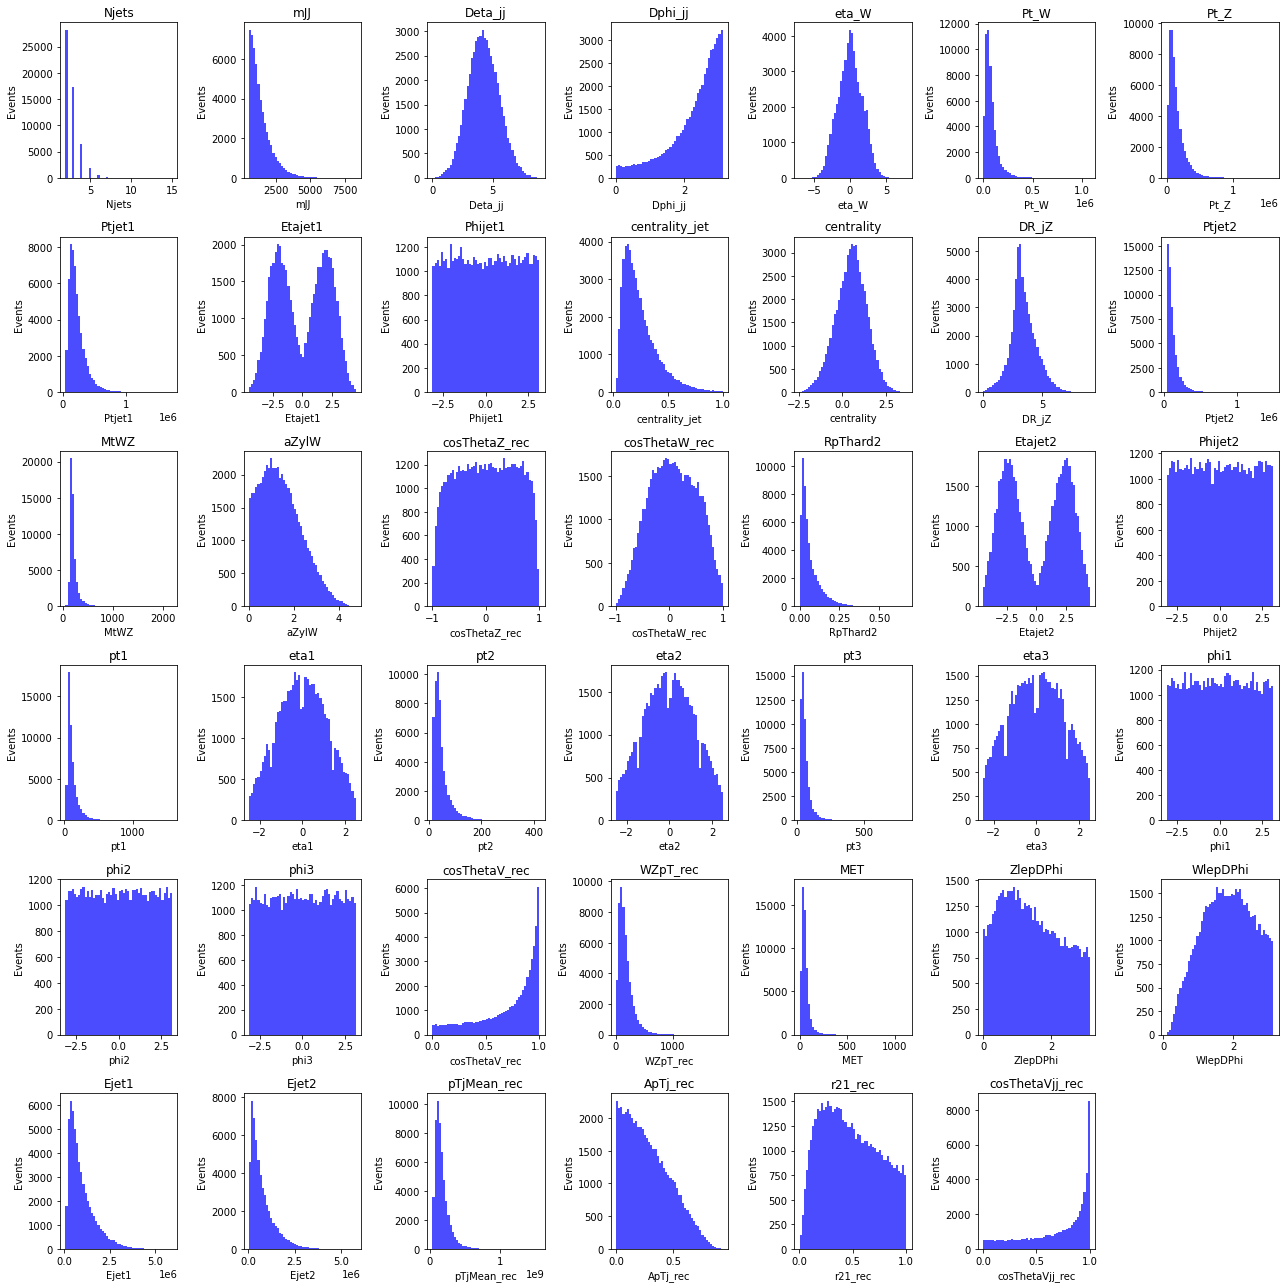

Plot:   0%|          | 0/41 [00:00<?, ?it/s]

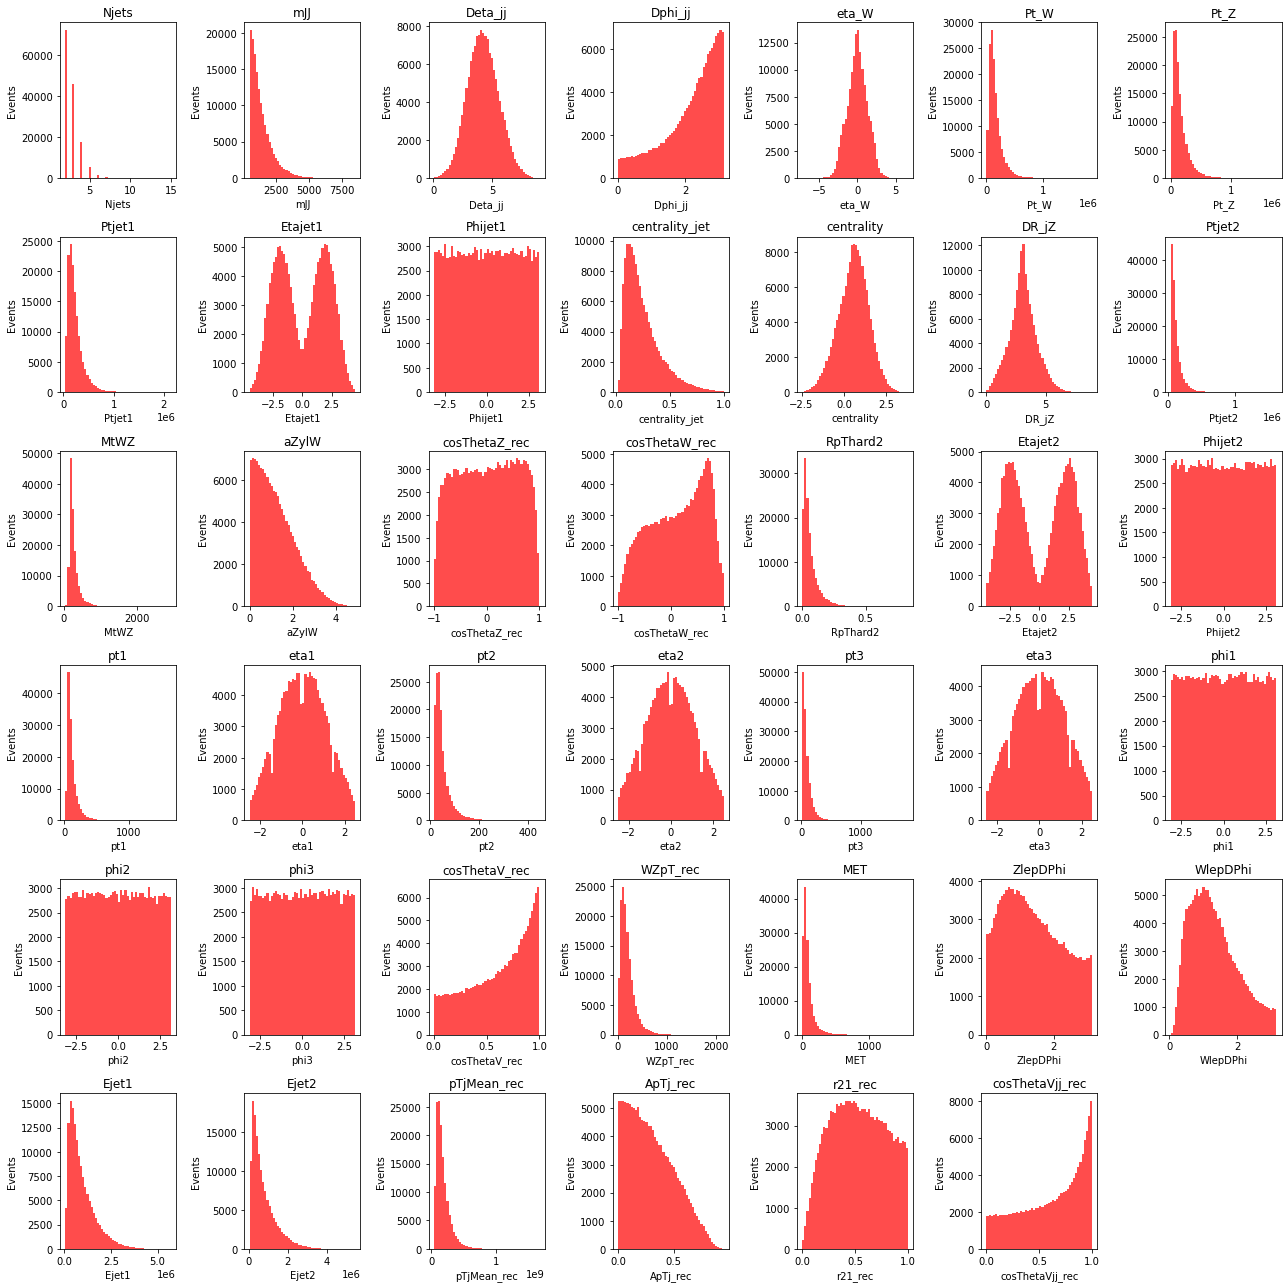

Plot:   0%|          | 0/41 [00:00<?, ?it/s]

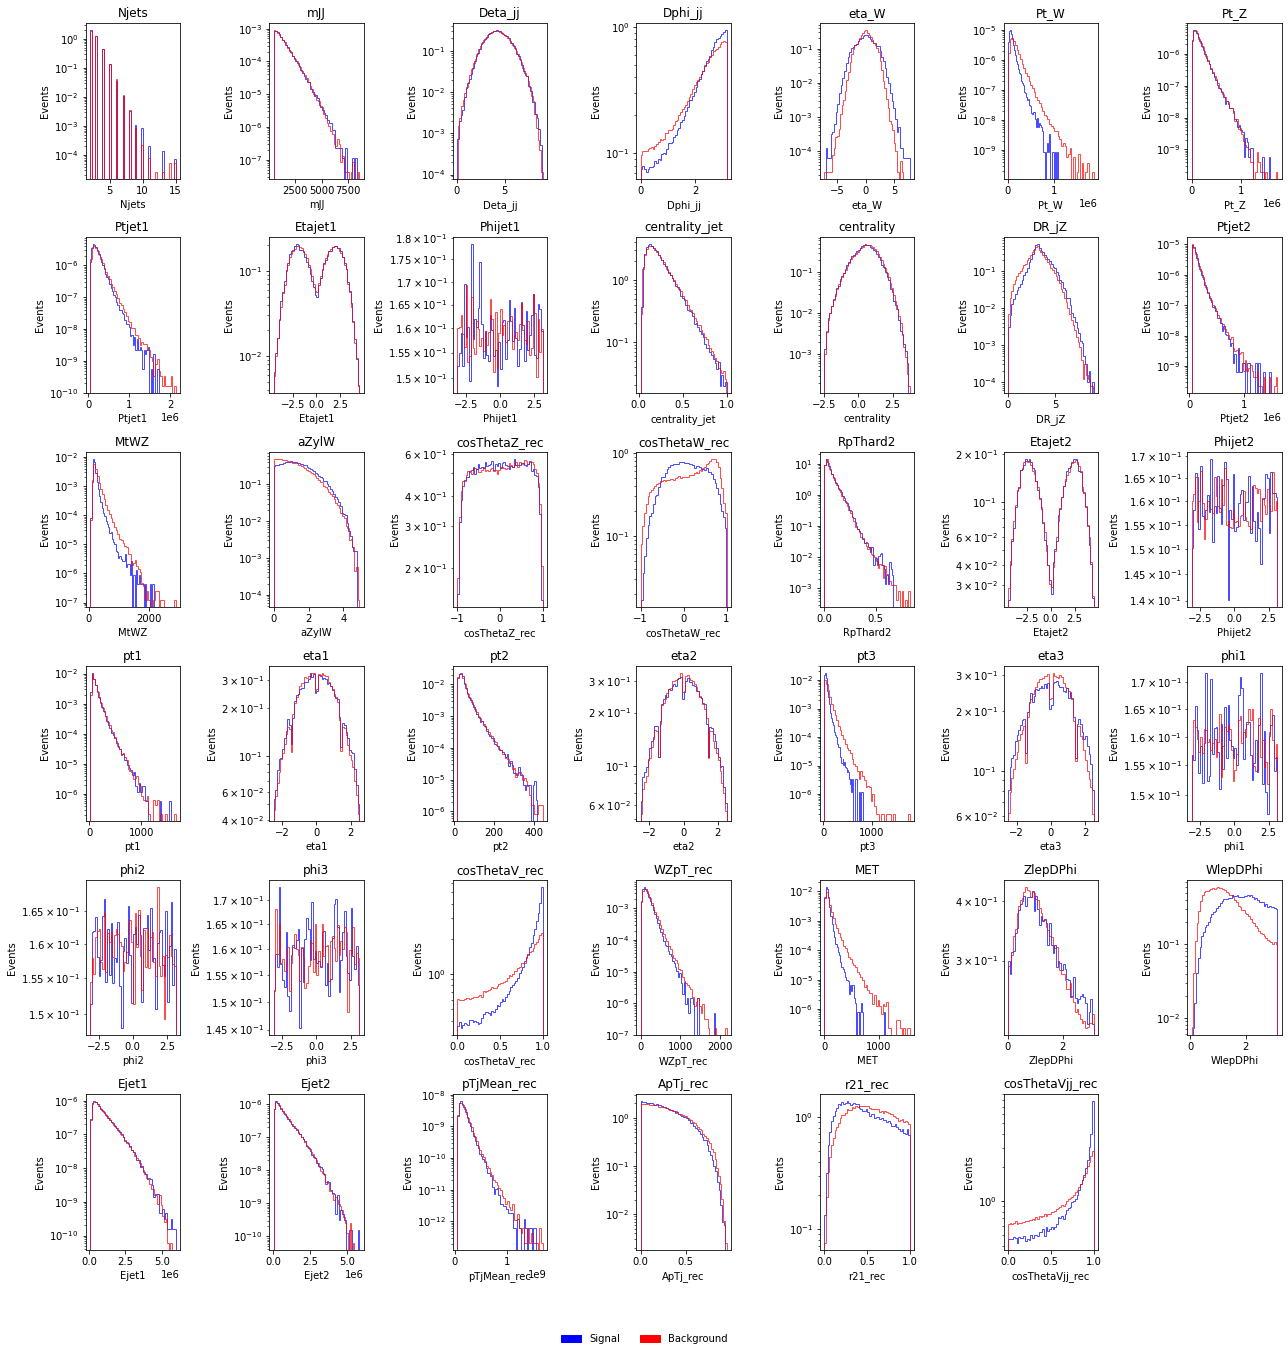

In [11]:
legend_signal = mpatches.Patch(color='blue', label='Signal')   
legend_background = mpatches.Patch(color='red', label='Background')
legend = [legend_signal,legend_background]

if plot_data:
    plot([signal_data], parameters, path_fig, "signal_data.pdf", ["blue"],False,[],parameters,False,limite_p,limits)
    plot([background_data], parameters, path_fig, "background_data.pdf", ["red"],False,[],parameters,False,limite_p,limits)
    plot([signal_data,background_data], parameters, path_fig, "signal_background_data.pdf", ["blue","red"],True,legend,parameters,False,limite_p,limits)

## Process DATA

In [12]:
print(signal_data.shape,background_data.shape)
X = np.concatenate((signal_data, background_data), axis=0)
Y = np.concatenate((signal_label, background_label))

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X[:,:41])
print(np.shape(X_scaled))
X_scaled = np.concatenate((X_scaled,np.array([X[:,41]]).T),axis=1)

joblib.dump(scaler, f"../Weights/DNN3_{name_dnn}_WW_scaler.save") 


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)


print(X_train.shape,X_test.shape)
print(Y_train.shape,Y_test.shape)


print(np.sum(Y_train))


X_train_weight = X_train[:,41]
X_train = np.delete(X_train,41,axis=1)
print(X_train.shape)

X_test_weight = X_test[:,41]
X_test = np.delete(X_test,41,axis=1)
print(X_test.shape)

(54586, 42) (143135, 42)
(197721, 41)
(158176, 42) (39545, 42)
(158176,) (39545,)
43710.0
(158176, 41)
(39545, 41)


# Correlation

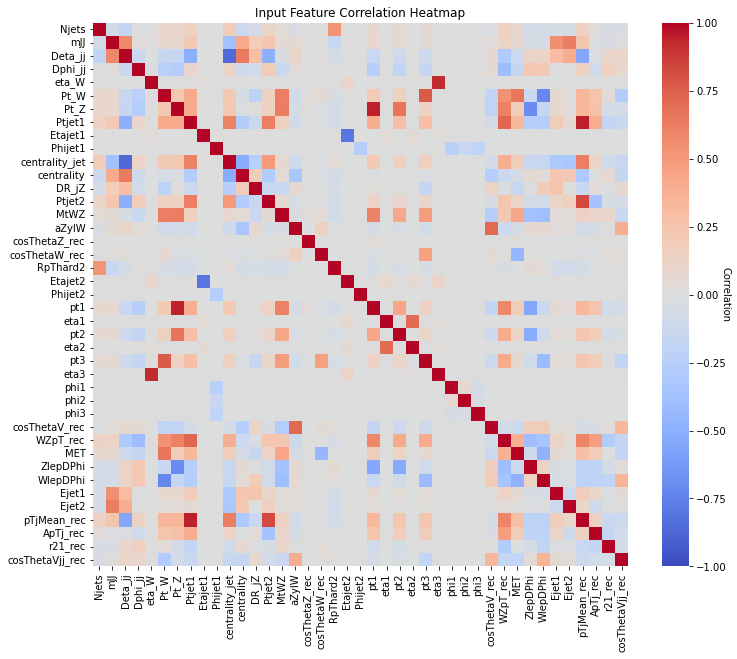

In [13]:
non_zero_var_cols = np.var(X_train, axis=0) != 0

selected_feature_names = [parameters[i] for i in range(len(parameters)) if non_zero_var_cols[i]]

correlation_matrix = np.corrcoef(X_train[:, non_zero_var_cols], rowvar=False)

plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", xticklabels=selected_feature_names, yticklabels=selected_feature_names, vmin=-1, vmax=1)
cbar = heatmap.collections[0].colorbar
cbar.set_label('Correlation',rotation=270)
plt.xticks(rotation=90)
plt.title('Input Feature Correlation Heatmap')
plt.savefig(path_fig+"correlation_matrix.pdf",bbox_inches="tight")
plt.show()

# Hyperparameters tunning

In [14]:

def build_model(hp):
    model = Sequential()
    
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=128, step=32),
                    input_dim=len(parameters), activation='relu'))
    
    for i in range(hp.Int('num_layers', min_value=1, max_value=15)):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    return model


if optimize:
    tuner = BayesianOptimization(build_model,
                         objective=metric_monitoring_tuner,
                         max_trials=tune_trials,
                         directory='../tuner_dir',
                         project_name=f'{name_dnn}_3_WW')
    
    early_stopping_HP = EarlyStopping(monitor=metric_monitoring, patience=patience)

    tuner.search(X_train, Y_train, epochs=epochs_tuner, validation_data=(X_test, Y_test), callbacks=[early_stopping_HP])

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters: {best_hps}")

    model = tuner.hypermodel.build(best_hps)

Trial 10 Complete [00h 11m 03s]
val_accuracy: 0.7249715328216553

Best val_accuracy So Far: 0.7665444612503052
Total elapsed time: 01h 37m 49s
Best Hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7ff26ad8ce50>


2024-06-27 17:53:59.522372: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1043c9b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-06-27 17:53:59.522443: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-06-27 17:53:59.547875: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-27 17:54:00.213017: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Model

In [15]:
if load:
    model = keras.models.load_model(f'../Weights/DNN3_{name_dnn}_WW_weights.h5')



model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 64)                2688      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dense_16 (Dense)            (None, 96)                6240      
                                                                 
 dense_17 (Dense)            (None, 96)                9312      
                                                                 
 dense_18 (Dense)            (None, 256)               24832     
                                                                 
 dense_19 (Dense)            (None, 160)              

# Fit

In [16]:
if train:
    early_stopping = EarlyStopping(monitor=metric_monitoring, patience=patience, restore_best_weights=True)
    
    history = model.fit(X_train, Y_train, epochs=epochs_train, batch_size=batch_size, validation_data=(X_test, Y_test), callbacks=[early_stopping])

model.save(f"../Weights/DNN3_{name_dnn}_WW_weights.h5")

Epoch 1/100
4943/4943 [==============================] - 60s 11ms/step - loss: 0.5150 - accuracy: 0.7513 - val_loss: 0.5003 - val_accuracy: 0.7604
Epoch 2/100
4943/4943 [==============================] - 54s 11ms/step - loss: 0.4978 - accuracy: 0.7597 - val_loss: 0.4935 - val_accuracy: 0.7574
Epoch 3/100
4943/4943 [==============================] - 54s 11ms/step - loss: 0.4949 - accuracy: 0.7605 - val_loss: 0.5106 - val_accuracy: 0.7468
Epoch 4/100
4943/4943 [==============================] - 49s 10ms/step - loss: 0.4920 - accuracy: 0.7621 - val_loss: 0.4883 - val_accuracy: 0.7626
Epoch 5/100
4943/4943 [==============================] - 43s 9ms/step - loss: 0.4898 - accuracy: 0.7631 - val_loss: 0.4980 - val_accuracy: 0.7629
Epoch 6/100
4943/4943 [==============================] - 43s 9ms/step - loss: 0.4887 - accuracy: 0.7642 - val_loss: 0.4982 - val_accuracy: 0.7620
Epoch 7/100
4943/4943 [==============================] - 43s 9ms/step - loss: 0.4878 - accuracy: 0.7632 - val_loss: 0.48

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


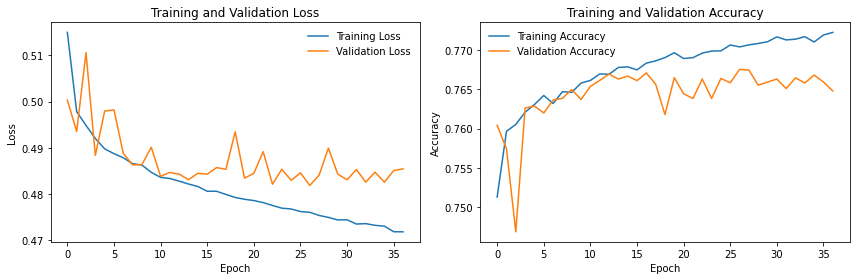

In [17]:
if train:
    train_loss = history.history['loss']
    train_accuracy = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(frameon=False)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)

    plt.tight_layout()
    plt.savefig(path_fig+"loss_accuracy.pdf",bbox_inches="tight")
    plt.show()

# Accuracy

In [18]:
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

1236/1236 [==============================] - 3s 2ms/step - loss: 0.4818 - accuracy: 0.7676
Test Loss: 0.4818, Test Accuracy: 0.7676


# Variables rank

In [19]:
@tf.function
def compute_gradients(input_data):
    with tf.GradientTape() as tape:
        tape.watch(input_data)
        predictions = model(input_data)
    gradients = tape.gradient(predictions, input_data)
    return gradients

input_gradients = compute_gradients(tf.convert_to_tensor(X_train, dtype=tf.float32)).numpy()

mean_gradients = np.mean(np.abs(input_gradients), axis=0)

sorted_indices = np.argsort(mean_gradients)[::-1]

for i, idx in enumerate(sorted_indices):
        
    print(f'{parameters[idx]} - Rank: {i+1}, Gradient: {mean_gradients[idx]:.4f}')

Pt_W - Rank: 1, Gradient: 1.6978
pt3 - Rank: 2, Gradient: 1.5753
MtWZ - Rank: 3, Gradient: 1.5557
MET - Rank: 4, Gradient: 0.8808
WZpT_rec - Rank: 5, Gradient: 0.6997
cosThetaW_rec - Rank: 6, Gradient: 0.2808
Ptjet2 - Rank: 7, Gradient: 0.2395
pTjMean_rec - Rank: 8, Gradient: 0.2069
aZylW - Rank: 9, Gradient: 0.1803
pt1 - Rank: 10, Gradient: 0.1637
WlepDPhi - Rank: 11, Gradient: 0.1624
DR_jZ - Rank: 12, Gradient: 0.1428
Ptjet1 - Rank: 13, Gradient: 0.1419
Pt_Z - Rank: 14, Gradient: 0.1347
cosThetaV_rec - Rank: 15, Gradient: 0.1333
eta3 - Rank: 16, Gradient: 0.1117
RpThard2 - Rank: 17, Gradient: 0.1058
Njets - Rank: 18, Gradient: 0.1012
ApTj_rec - Rank: 19, Gradient: 0.1010
mJJ - Rank: 20, Gradient: 0.0980
Deta_jj - Rank: 21, Gradient: 0.0960
pt2 - Rank: 22, Gradient: 0.0930
centrality - Rank: 23, Gradient: 0.0796
Etajet1 - Rank: 24, Gradient: 0.0790
centrality_jet - Rank: 25, Gradient: 0.0787
Dphi_jj - Rank: 26, Gradient: 0.0743
ZlepDPhi - Rank: 27, Gradient: 0.0673
Etajet2 - Rank: 28,

2024-06-27 19:52:24.728072: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 161972224 exceeds 10% of free system memory.
2024-06-27 19:52:25.481479: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 323944448 exceeds 10% of free system memory.


# Predictions

In [20]:
Y_pred = model.predict(X_test)

1236/1236 [==============================] - 2s 2ms/step


# Metrics

In [21]:
Y_pred_binary = (Y_pred > 0.5).astype(int)


conf_matrix = confusion_matrix(Y_test, Y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(Y_test, Y_pred_binary)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[26320  2349]
 [ 6843  4033]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85     28669
         1.0       0.63      0.37      0.47     10876

    accuracy                           0.77     39545
   macro avg       0.71      0.64      0.66     39545
weighted avg       0.75      0.77      0.75     39545



## Plot parameters 

ROC-AUC Score: 0.7839


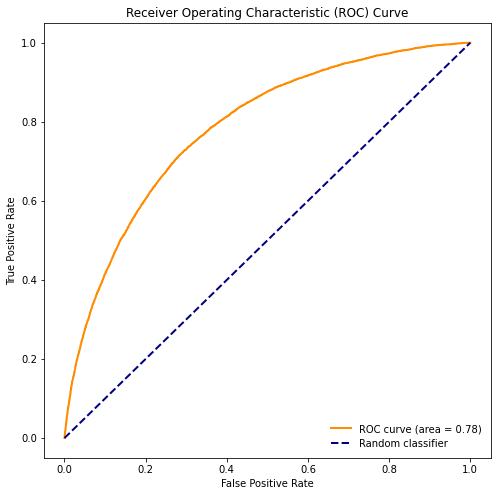

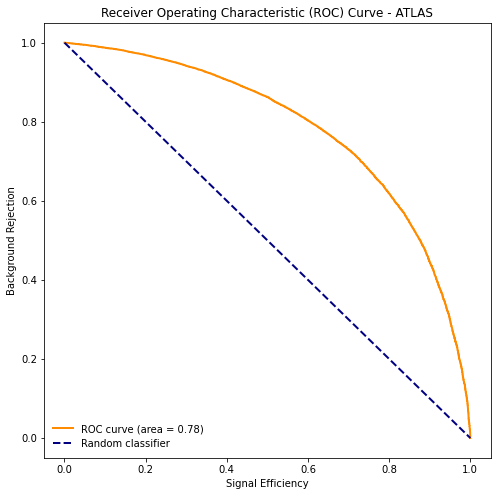

PR-AUC: 0.5718


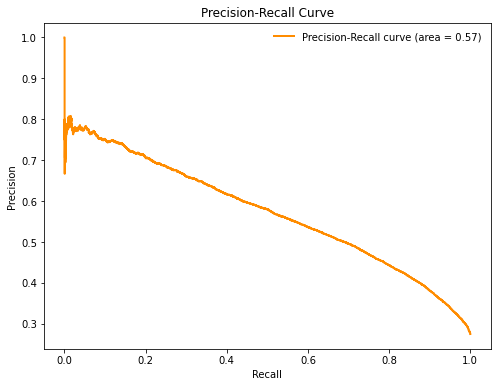

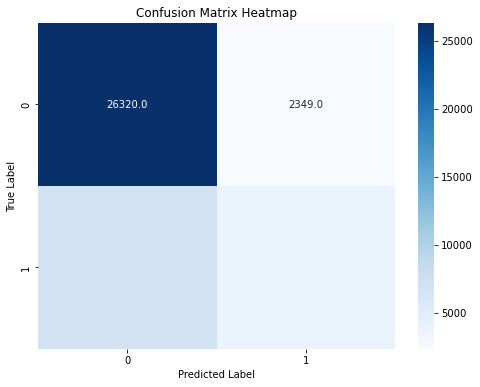

In [22]:
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = roc_auc_score(Y_test, Y_pred)
print(f'ROC-AUC Score: {roc_auc:.4f}')




plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random classifier")
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')


plt.legend(loc='lower right',frameon=False)
plt.savefig(path_fig+"roc_curve.pdf")
plt.show()



plt.figure(figsize=(8, 8))
plt.plot(tpr, 1-fpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--', label="Random classifier")
    
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver Operating Characteristic (ROC) Curve - ATLAS')


plt.legend(loc='lower left',frameon=False)
plt.savefig(path_fig+"roc_curve_atlas.pdf")
plt.show()


precision, recall, _ = precision_recall_curve(Y_test, Y_pred)
auc_pr = auc(recall, precision)
print(f'PR-AUC: {auc_pr:.4f}')

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(auc_pr))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best',frameon=False)
plt.savefig(path_fig+"precision_recall_curve.pdf")
plt.show()


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.1f', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.savefig(path_fig+"confusion_matrix.pdf")
plt.show()

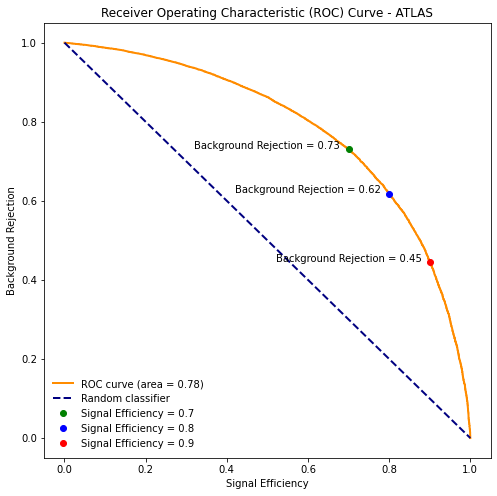

In [23]:
plt.figure(figsize=(8, 8))
plt.plot(tpr, 1 - fpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--', label="Random classifier")

color = ["g","b","r"]
for indx,i in enumerate([0.70,0.80,0.90]):
    signal_efficiency_interest = i
    index_interest = (np.abs(tpr - signal_efficiency_interest)).argmin()

    fpr_interest = fpr[index_interest]
    background_rejection_interest = 1 - fpr_interest
    

    plt.plot(signal_efficiency_interest, background_rejection_interest, 'o'+color[indx], label=f'Signal Efficiency = {i}')

    plt.annotate(f'Background Rejection = {background_rejection_interest:.2f}',
                 xy=(signal_efficiency_interest, background_rejection_interest),
                 xytext=(signal_efficiency_interest - 0.2, background_rejection_interest + 0.001),
                 ha='center')


plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('Receiver Operating Characteristic (ROC) Curve - ATLAS')


plt.legend(loc='lower left', frameon=False)
plt.savefig(path_fig+"roc_curve_atlas_cuts.pdf")
plt.show()
